# Homework Problem 0: Making sure you're set up with python
### You will need to be able to run all of these cells without error

In [2]:
import numpy as np
import pandas as pd 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tqdm


for i in tqdm.tqdm(range(3)):
    print("look at the pretty progress bar")


100%|██████████| 3/3 [00:00<00:00, 3007.39it/s]

look at the pretty progress bar
look at the pretty progress bar
look at the pretty progress bar


In [4]:
# make sure numpy works
arr = np.arange(30).reshape(10, 3)
arr.sum(axis=0)

array([135, 145, 155])

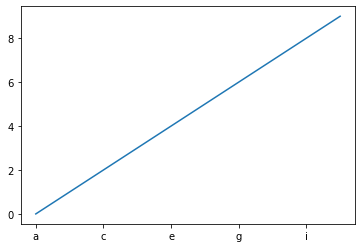

In [5]:
# make sure pandas works
pd.Series(range(10), index=list("abcdefghij")).plot()

In [6]:
# make sure scikit learn works
from sklearn.preprocessing import normalize

arr = np.arange(30).reshape(10, 3)
new_arr = normalize(arr)
(new_arr * new_arr).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
from tensorflow.keras.utils import to_categorical

arr = np.array([[1, 2, 1, 0, 5], [3, 4, 1, 0, 5]])
assert to_categorical(arr).shape == (2, 5, 6)

In [10]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

K.clear_session()
inpt = Input(shape=(10,))
mat = Dense(1, input_shape=(10,))

res = mat(K.variable(np.ones((10, 1))))

if tf.__version__.startswith("1"):
    print(
        f"you have tensorflow version {tf.__version__}."
        "Your code may not be compatible with everything we do in class"
    )
    result = K.eval(res)
else:
    result = res.numpy()
    assert (result == K.eval(res)).all()

print(result)

[[-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]
 [-0.29745626]]


In [11]:
K.clear_session()
inpt = Input(shape=(10,))
mat = Dense(1, input_shape=(10,))
outpt = mat(inpt)

model = Model(inpt, outpt)
model.compile("adam", loss="binary_crossentropy")
assert model.count_params() == 11
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


# Homework Problem 1: Company Descriptions from Wikipedia
Downloading data from the web is a large part of working with text.
Importantly, it can be difficult to find the __right__ data. 
Here, we will download the company descriptions from wikipedia for the current set of S&P500 companies. 

## The `wikipedia` package
You can install it with `pip install wikipedia`

We will use `wikipeda.page` to grab data
```python
import wikipedia

page = wikipedia.page(page_url)
print(page.content)
```

In [12]:
import numpy as np
import pandas as pd
%pylab inline

from tqdm import tqdm
import wikipedia
from time import sleep

Populating the interactive namespace from numpy and matplotlib


C:\Users\a\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Part 0: get the list of the S&P500 companies
### Hint, a `wikipedia` page has a method `html()` which returns the html from the page
### pandas has `read_html` https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_html.html

In [13]:
sp500_url = 'List_of_S%26P_500_companies'
# your code here

In [14]:
import requests
from bs4 import BeautifulSoup

r = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
soup = BeautifulSoup(r.content)
table = soup.findAll(name = "table")[0]

In [15]:
entries_raw_data = table.tbody.findAll('tr')
companies_wiki_url = {}
companies_sector = {}
companies_sub_industry = {}
for idx in range(1,len(entries_raw_data)):
    entry = entries_raw_data[idx]
    company = entry.findAll('td')[1].a['title']
    GICS_sector = entry.findAll('td')[3].text.replace("\n", "")
    GICS_sub_industry = entry.findAll('td')[4].text.replace("\n", "")
    url = entry.findAll('td')[1].a['href']
    if companies_wiki_url.get(company,0) != 0:
        assert companies_wiki_url[company] == url
    companies_wiki_url[company] = url
    companies_sector[company] = GICS_sector
    companies_sub_industry[company] = GICS_sub_industry

companies = [i for i in companies_wiki_url]

## Part 2: For every S&P500 company, get the page content

In [16]:
import json
# your code here. We suggest that you save your results
# to a json file so that you don't need to re-scrape
id_map = {}
data = {}
for company in companies:
    url = "https://en.wikipedia.org/" + companies_wiki_url[company]
    company_soup = BeautifulSoup(requests.get(url).content)
    info_url = "https://en.wikipedia.org/" + company_soup.findAll(title= "More information about this page")[0]['href']
    info_soup = BeautifulSoup(requests.get(info_url).content)
    _id = info_soup.findAll(id = 'mw-pageinfo-article-id')[0].text[7:]
    id_map[company] = _id
    try:
        data[company] = wikipedia.page(pageid=_id).content
    except:
        print("error in finding company page: " + company)
print("found {} results".format(len(data)))

error in finding company page: Pool Corporation (page does not exist)
found 499 results


In [19]:
j_data = json.dumps(data)
file_obj = open('data.json','w')
file_obj.write(j_data)
file_obj.close()

## Part 3: Content length
 - For every page, compute the length of the text (how many characters)
 - What is the mean length(number of characters) for each gics sector. 

In [20]:
companies_sector = pd.Series(companies_sector, name = 'sector')
content_length = {}
for company in data:
    content_length[company] = len(data[company])
content_length = pd.Series(content_length, name = 'content_length')
content_length = pd.concat([content_length,companies_sector],axis = 1)
print(content_length)
print(content_length.groupby('sector').agg({'content_length':'mean'}))

                                        content_length                  sector
3M                                             17762.0             Industrials
Abbott Laboratories                            17830.0             Health Care
AbbVie                                          7624.0             Health Care
Abiomed                                         5918.0             Health Care
Accenture                                      11950.0  Information Technology
...                                                ...                     ...
Zebra Technologies                              3684.0  Information Technology
Zimmer Biomet                                   3663.0             Health Care
Zions Bancorporation                            5671.0              Financials
Zoetis                                          4978.0             Health Care
Pool Corporation (page does not exist)             NaN  Consumer Discretionary

[500 rows x 2 columns]
                        cont

## Part 4: Count how many times `computer` appears in the content for each company
 - what is the mean number of times it occurs in each sector?
 - Do these results make sense

In [21]:
# your code here
count_computer = {}
for company in data:
    word_list = data[company].lower().split()
    count_computer[company] = word_list.count('computer')
count_computer = pd.Series(count_computer, name = 'count_computer')
print(count_computer.sort_values())
count_computer = pd.concat([count_computer,companies_sector],axis = 1)
print(count_computer.groupby('sector').agg({'count_computer':'mean'}).sort_values('count_computer',ascending = False))

3M                           0
The Mosaic Company           0
Moody's Corporation          0
Monster Beverage             0
Monolithic Power Systems     0
                            ..
Texas Instruments            9
IBM                         11
Apple Inc.                  14
Microsoft                   15
Intel                       25
Name: count_computer, Length: 499, dtype: int64
                        count_computer
sector                                
Information Technology        2.229730
Communication Services        0.565217
Industrials                   0.418919
Consumer Discretionary        0.344262
Health Care                   0.218750
Energy                        0.190476
Financials                    0.138462
Consumer Staples              0.062500
Utilities                     0.035714
Materials                     0.000000
Real Estate                   0.000000


The result makes sense, IT companies mentions 'computer' much more likely and at much higher magnitutute than others

## Part 5: repeat part 4 with lots of words
 - try `['computer', 'oil', 'debt', 'drug', 'building', 'food']`
 - add your own words

In [22]:
words = ['computer', 'oil', 'debt', 'drug', 'building', 'food', 'service']
# one way to do this is to make a dataframe of counts,
# initialize all to 0, and then loop through and count the occurences
counts = pd.DataFrame(0, index=companies, columns=words)
for company in companies:
    try:
        word_list = data[company].lower().split()
        for word in words:
            counts.loc[company,word] = word_list.count(word)
    except:
        print(company)

counts = pd.concat([counts,companies_sector],axis = 1)
# your code here

Pool Corporation (page does not exist)


In [23]:
counts.groupby('sector').mean()

,computer,oil,debt,drug,building,food,service
sector,,,,,,,
Communication Services,0.565217,0.043478,0.347826,0.086957,2.130435,0.347826,7.652174
Consumer Discretionary,0.338710,0.161290,0.225806,0.129032,0.903226,2.048387,1.451613
Consumer Staples,0.062500,0.562500,0.031250,0.437500,0.406250,6.468750,1.093750
Energy,0.190476,20.714286,0.095238,0.000000,0.904762,0.095238,1.190476
Financials,0.138462,0.538462,0.446154,0.061538,1.600000,0.092308,0.830769
Health Care,0.218750,0.031250,0.062500,3.578125,0.156250,0.781250,0.390625
Industrials,0.418919,0.472973,0.135135,0.027027,1.000000,0.216216,1.905405
Information Technology,2.229730,0.148649,0.094595,0.027027,0.594595,0.094595,2.891892
Materials,0.000000,0.642857,0.071429,0.000000,0.857143,1.285714,0.214286
